# Phần 1: Chọn mô hình

## 1.Import các thư viện cần thiết

In [451]:
# !pip install pandas numpy matplotlib seaborn lifetimes scikit-learn xgboost tqdm
# !pip install lifetimes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta


from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import summary_data_from_transaction_data


from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, roc_auc_score, average_precision_score, make_scorer
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score

import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.dpi']=120

## 2.Tải lên các bảng dữ liệu

In [452]:
customers = pd.read_csv("C:/Users/meta/Documents/Olist 10.11/olist_customers_dataset.csv")
orders = pd.read_csv("C:/Users/meta/Documents/Olist 10.11/olist_orders_dataset.csv")
items = pd.read_csv("C:/Users/meta/Documents/Olist 10.11/olist_order_items_dataset.csv")
payments = pd.read_csv("C:/Users/meta/Documents/Olist 10.11/olist_order_payments_dataset.csv")
reviews = pd.read_csv("C:/Users/meta/Documents/Olist 10.11/olist_order_reviews_dataset.csv")

In [453]:
# Kiểm tra kích thước và cột
print(customers.shape, orders.shape, items.shape, payments.shape, reviews.shape)

(99441, 5) (99441, 8) (112650, 7) (103886, 5) (99224, 7)


### 2.1. Table orders

In [454]:
orders.head(4)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00


In [455]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


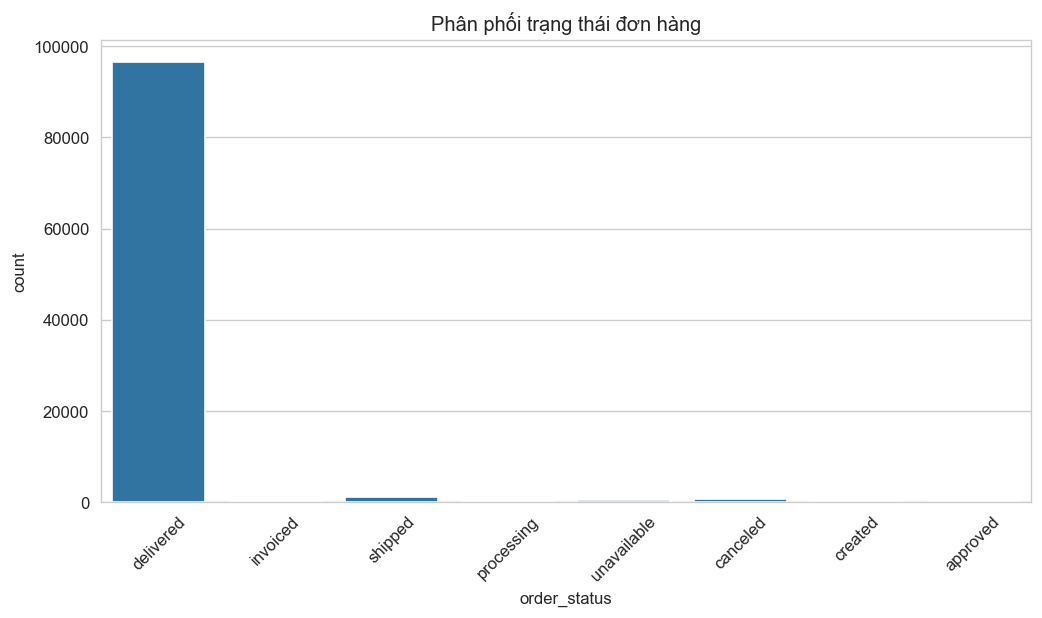

In [456]:
# Phân tích trạng thái đơn hàng
plt.figure(figsize=(10, 5))
sns.countplot(data=orders, x='order_status')
plt.title("Phân phối trạng thái đơn hàng")
plt.xticks(rotation=45)
plt.show()

In [457]:
status_summary = (
    orders['order_status']
    .value_counts()
    .to_frame('count')
)

status_summary['percent'] = (
    orders['order_status']
    .value_counts(normalize=True) * 100
).round(2)

print(status_summary)

              count  percent
order_status                
delivered     96478    97.02
shipped        1107     1.11
canceled        625     0.63
unavailable     609     0.61
invoiced        314     0.32
processing      301     0.30
created           5     0.01
approved          2     0.00


* Lưu ý: Ở phần phân tích phía sau, chỉ giữ lại các đơn hàng đã có trạng thái chuyển "delivered"

In [458]:
#Tạo funtion để tính tỉ lệ giá trị bị null trong các hàng
def calc_null_rate(df):
  newdf=df.isnull().sum().to_frame('null_count')
  newdf[['null_rate']]=newdf[['null_count']]/len(df)
  return newdf.sort_values(by=['null_rate'],ascending=False)

In [459]:
calc_null_rate(orders)

,null_count,null_rate
order_delivered_customer_date,2965,0.029817
order_delivered_carrier_date,1783,0.017930
order_approved_at,160,0.001609
order_id,0,0.000000
order_purchase_timestamp,0,0.000000
order_status,0,0.000000
customer_id,0,0.000000
order_estimated_delivery_date,0,0.000000


* Nhận xét: 3 cột đầu tiên có giá trị null nhưng phần phân tích phía dưới không dùng nên sẽ lược bỏ

### 2.2. Table items

In [460]:
items.head(4)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79


In [461]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [462]:
calc_null_rate(items)

,null_count,null_rate
order_id,0,0.0
order_item_id,0,0.0
product_id,0,0.0
seller_id,0,0.0
shipping_limit_date,0,0.0
price,0,0.0
freight_value,0,0.0


In [463]:
items['order_id'].nunique()

98666

Nhận xét: Vì mỗi đơn hàng có nhiều order_item khác nhau, nên số dòng tương ứng với số đơn hàng sẽ nhiều hơn số đơn riêng biệt (unique order id)

In [464]:
items.describe()

,order_item_id,price,freight_value
count,112650.000000,112650.000000,112650.000000
mean,1.197834,120.653739,19.990320
std,0.705124,183.633928,15.806405
min,1.000000,0.850000,0.000000
25%,1.000000,39.900000,13.080000
50%,1.000000,74.990000,16.260000
75%,1.000000,134.900000,21.150000
max,21.000000,6735.000000,409.680000


+ Nhận xét: Cột price và freight value không xuất hiện giá trị âm, phù hợp để thực hiện các phần tính toán phía dưới

In [465]:
# Kiểm tra tỷ lệ freight_value = 0
zero_freight = (items['freight_value'] == 0).sum()
total_rows = len(items)
print(f"Số dòng freight_value = 0: {zero_freight} ({zero_freight/total_rows*100:.2f}%)")

Số dòng freight_value = 0: 383 (0.34%)


+ Nhận xét: Có thể đây là những đơn hàng freeship nên giá trị vận chuyển = 0 là bình thường (Không loại bỏ)

### 2.3. Table customers

In [466]:
customers.head(4)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP


In [467]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [468]:
customers['customer_id'].nunique()

99441

In [469]:
customers['customer_unique_id'].nunique()

96096

* Nhận xét: Có 99,441 đơn hàng được gán cho 96,096 khách hàng thực tế
  → Tức là chỉ có khoảng 3,345 khách hàng đã mua từ 2 lần trở lên

In [470]:
repeat_customers = (
    customers.groupby('customer_unique_id')['customer_id']
    .nunique()
    .reset_index(name='order_count')
)

repeat_customers['is_repeat'] = repeat_customers['order_count'] > 1
repeat_customers['is_repeat'].value_counts(normalize=True) * 100

is_repeat
False    96.881244
True      3.118756
Name: proportion, dtype: float64

* Nhận xét: Nghĩa là khoảng 3.12% khách hàng thực đã mua nhiều hơn 1 lần và gần 97% khách hàng chỉ mua 1 lần duy nhất

In [471]:
# In ra số khách hàng ở mỗi tháng

orders_cust = orders.merge(customers, on='customer_id', how='left')

# Chuyển cột thời gian sang datetime
orders_cust['order_date'] = pd.to_datetime(orders_cust['order_purchase_timestamp'])

# Tạo cột tháng
orders_cust['order_month'] = orders_cust['order_date'].dt.to_period('M')

# Tính số khách hàng unique mỗi tháng (dựa trên customer_unique_id)
unique_users_by_month = (
    orders_cust.groupby('order_month')['customer_unique_id']
    .nunique()
    .reset_index()
    .rename(columns={'customer_unique_id': 'n_unique_users'})
)

# Chuyển order_month về dạng timestamp
unique_users_by_month['order_month'] = unique_users_by_month['order_month'].dt.to_timestamp()

print(unique_users_by_month.head(30))

   order_month  n_unique_users
0   2016-09-01               4
1   2016-10-01             321
2   2016-12-01               1
3   2017-01-01             765
4   2017-02-01            1755
5   2017-03-01            2642
6   2017-04-01            2372
7   2017-05-01            3625
8   2017-06-01            3180
9   2017-07-01            3947
10  2017-08-01            4246
11  2017-09-01            4212
12  2017-10-01            4561
13  2017-11-01            7430
14  2017-12-01            5603
15  2018-01-01            7166
16  2018-02-01            6569
17  2018-03-01            7115
18  2018-04-01            6882
19  2018-05-01            6814
20  2018-06-01            6128
21  2018-07-01            6230
22  2018-08-01            6460
23  2018-09-01              14
24  2018-10-01               4


* Nhận xét: Mặc dù Dataset từ 9/2016 - 10/2018, tuy nhiên bị thiếu dữ liệu của tháng 11/2016, đồng thời số khách hàng của tháng 9,10,12 năm 2016 và tháng 9,10 của năm 2018 rất nhỏ
  * Vì thế, bài phân tích chỉ tập trung vào khoảng 1/2017 đến 6/2018

## 3.Gộp bảng và lọc điều kiện

In [472]:
# Giữ đơn đã giao thành công (order_status là delivered)
orders = orders[orders['order_status'] == 'delivered'].copy()
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'], errors='coerce')

# Tính giá trị đơn hàng = price + freight_value 
items['order_value'] = items['price'] + items['freight_value']
order_val = items.groupby('order_id', as_index=False)['order_value'].sum()

# Merge bảng giao dịch 
trans = (
    orders[['order_id', 'customer_id', 'order_purchase_timestamp']]
    .merge(order_val, on='order_id', how='left')
    .merge(customers[['customer_id', 'customer_unique_id', 'customer_state']], on='customer_id', how='left')
    .rename(columns={'order_purchase_timestamp': 'order_date'})
    [['order_id', 'customer_unique_id', 'order_date', 'order_value', 'customer_state']]
#  .dropna()
#  .drop_duplicates()
)
trans['order_date'] = pd.to_datetime(trans['order_date'], errors='coerce')

# Chỉ giữ lại dữ liệu từ 01/01/2017 trở đi
trans = trans[trans['order_date'] >= '2017-01-01']
print("Tổng số giao dịch:", len(trans))
trans.head(3)


Tổng số giao dịch: 96211


,order_id,customer_unique_id,order_date,order_value,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,38.71,SP
1,53cdb2fc8bc7dce0b6741e2150273451,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:37,141.46,BA
2,47770eb9100c2d0c44946d9cf07ec65d,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:38:49,179.12,GO


In [473]:
trans.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96211 entries, 0 to 96477
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   order_id            96211 non-null  object        
 1   customer_unique_id  96211 non-null  object        
 2   order_date          96211 non-null  datetime64[ns]
 3   order_value         96211 non-null  float64       
 4   customer_state      96211 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 4.4+ MB


In [474]:
calc_null_rate(trans)

,null_count,null_rate
order_id,0,0.0
customer_unique_id,0,0.0
order_date,0,0.0
order_value,0,0.0
customer_state,0,0.0


## 4.EDA (phân phối & đặc điểm dữ liệu)

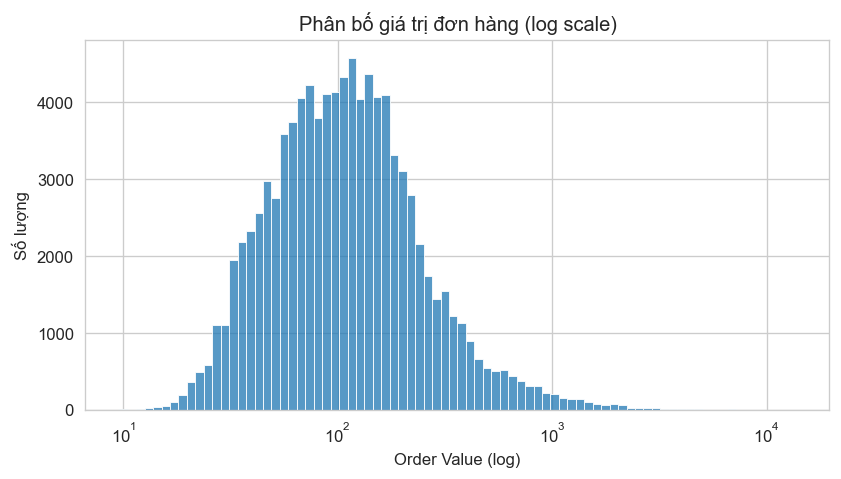

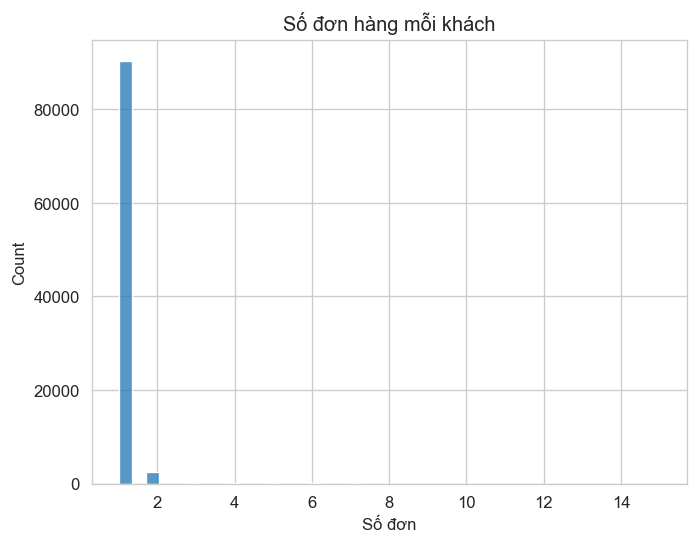

Tỷ lệ khách chỉ mua 1 lần: 97.0 %


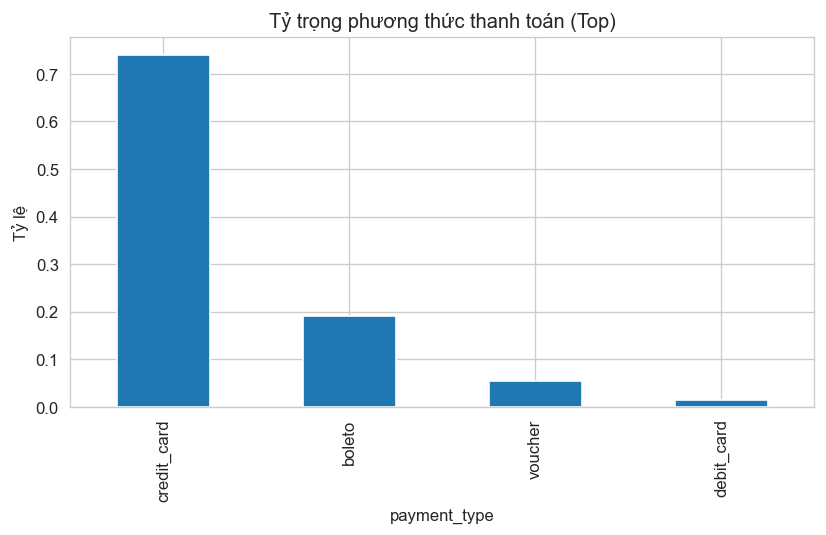

In [475]:
plt.figure(figsize=(8,4))
sns.histplot(trans['order_value'], bins=80, log_scale=True)
plt.title("Phân bố giá trị đơn hàng (log scale)")
plt.xlabel("Order Value (log)")
plt.ylabel("Số lượng"); plt.show()

# Phân phối số đơn theo khách
cust_orders = trans.groupby('customer_unique_id')['order_id'].nunique()
sns.histplot(cust_orders, bins=40)
plt.title("Số đơn hàng mỗi khách"); plt.xlabel("Số đơn"); plt.show()
print("Tỷ lệ khách chỉ mua 1 lần:", (cust_orders.eq(1).mean()*100).round(2), "%")

# Tỷ trọng phương thức thanh toán
pm = payments.merge(orders[['order_id']], on='order_id', how='inner')
share = pm['payment_type'].value_counts(normalize=True).head(6)
share.plot(kind='bar', figsize=(8,4))
plt.title("Tỷ trọng phương thức thanh toán (Top)"); plt.ylabel("Tỷ lệ"); plt.show()


## 5.Tách thời gian (Cutoff & Horizon) + Chia Train/Test

Train orders: 43357 | Test (horizon): 40344


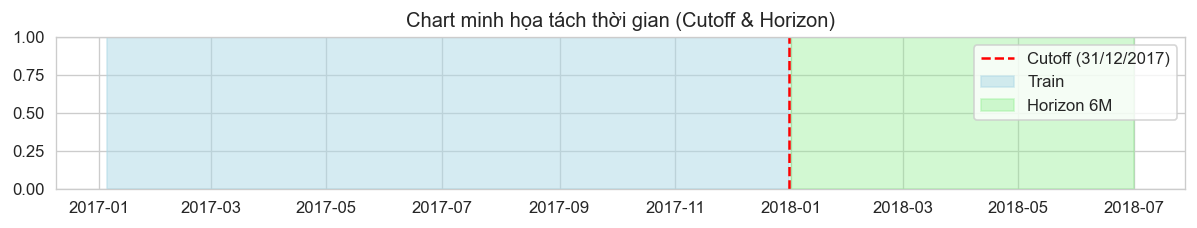

In [476]:
# Thiết lập mốc thời gian tách dữ liệu (temporal split)

# Trong đó:
# - CUTOFF: mốc tách train/test (31/12/2017)
# - H_START, H_END: giai đoạn dự báo CLV (01/2018–06/2018)
# - SNAPSHOT: điểm tham chiếu tính Recency

CUTOFF  = pd.Timestamp('2017-12-31')
H_START = CUTOFF + pd.Timedelta(days=1)
H_END   = H_START + pd.DateOffset(months=6)
SNAPSHOT = CUTOFF + pd.Timedelta(days=1)

# Chia dữ liệu:
# - train_tx: giao dịch trước cutoff (dùng huấn luyện)
# - test_tx : giao dịch sau cutoff (dùng đánh giá CLV thực tế)
train_tx = trans[trans['order_date'] <= CUTOFF].copy()
test_tx  = trans[(trans['order_date'] > CUTOFF) & (trans['order_date'] <= H_END)].copy()

# Lưu ý: Khách hàng chỉ xuất hiện sau cutoff (cold-start) sẽ bị loại tự động
# vì không có lịch sử trong train_tx → không thể dự báo CLV
print("Train orders:", len(train_tx), "| Test (horizon):", len(test_tx))

# Chart Cutoff & Horizon
plt.figure(figsize=(10,2))
plt.axvline(CUTOFF, color='r', linestyle='--', label='Cutoff (31/12/2017)')
plt.axvspan(train_tx['order_date'].min(), CUTOFF, color='lightblue', alpha=0.5, label='Train')
plt.axvspan(H_START, H_END, color='lightgreen', alpha=0.4, label='Horizon 6M')
plt.title("Chart minh họa tách thời gian (Cutoff & Horizon)")
plt.legend(); plt.tight_layout(); plt.show()


In [477]:
train_tx['customer_unique_id'].nunique()

42066

- Lúc này, tập train có khoảng 42066 unique customers

In [478]:
train_tx.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43357 entries, 0 to 96475
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   order_id            43357 non-null  object        
 1   customer_unique_id  43357 non-null  object        
 2   order_date          43357 non-null  datetime64[ns]
 3   order_value         43357 non-null  float64       
 4   customer_state      43357 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 2.0+ MB


## 6.Tính RFM (Recency–Frequency–Monetary)

In [479]:
# Tính RFM theo kiểu bình thường
# last  = ngày mua gần nhất (most recent purchase)
# first = ngày mua đầu tiên (khởi đầu mối quan hệ khách hàng)
# num   = số đơn hàng (frequency)
# spent = tổng tiền chi tiêu (monetary)

rfm_simple = (
    train_tx.groupby('customer_unique_id')
    .agg(
        last=('order_date', 'max'),      # lần mua gần nhất
        first=('order_date', 'min'),     # lần mua đầu tiên
        num=('order_id', 'nunique'),     # số đơn hàng duy nhất
        spent=('order_value', 'sum')     # tổng chi tiêu của khách
    )
)

rfm_simple['recency']   = (SNAPSHOT - rfm_simple['last']).dt.days
rfm_simple['T']         = (SNAPSHOT - rfm_simple['first']).dt.days
rfm_simple['frequency'] = rfm_simple['num']      # không trừ 1
rfm_simple['monetary']  = rfm_simple['spent'] / rfm_simple['num']

rfm_simple = rfm_simple[['recency', 'frequency', 'T', 'monetary']].reset_index()
rfm_simple.head(10)

,customer_unique_id,recency,frequency,T,monetary
0,0000f46a3911fa3c0805444483337064,296,1,296,86.22
1,0000f6ccb0745a6a4b88665a16c9f078,80,1,80,43.62
2,0004aac84e0df4da2b147fca70cf8255,47,1,47,196.89
3,0005e1862207bf6ccc02e4228effd9a0,302,1,302,150.12
4,0006fdc98a402fceb4eb0ee528f6a8d4,166,1,166,29.00
5,00082cbe03e478190aadbea78542e933,42,1,42,126.26
6,000a5ad9c4601d2bbdd9ed765d5213b3,142,1,142,91.28
7,000bfa1d2f1a41876493be685390d6d3,93,1,93,46.85
8,000c8bdb58a29e7115cfc257230fb21b,19,1,19,29.00
9,000de6019bb59f34c099a907c151d855,136,1,136,257.44


In [480]:
rfm_simple.describe()

,recency,frequency,T,monetary
count,42066.000000,42066.000000,42066.000000,42066.000000
mean,136.727571,1.030690,137.985428,159.910345
std,95.225645,0.194258,95.428196,226.197880
min,1.000000,1.000000,1.000000,10.070000
25%,47.000000,1.000000,48.000000,62.010000
50%,122.000000,1.000000,124.000000,104.190000
75%,212.000000,1.000000,214.000000,175.550000
max,360.000000,8.000000,360.000000,13664.080000


In [481]:
# Nhóm frequency
bins = [0, 1, 2, 3, rfm_simple['frequency'].max()]
labels = ['1', '2', '3', '>3']
rfm_simple['freq_group'] = pd.cut(rfm_simple['frequency'], bins=bins, labels=labels)

# Tính số user và %
freq_summary = rfm_simple['freq_group'].value_counts().sort_index().to_frame('num_users')
freq_summary['percent'] = (freq_summary['num_users'] / freq_summary['num_users'].sum() * 100).round(2)

print(freq_summary)


            num_users  percent
freq_group                    
1               40897    97.22
2                1076     2.56
3                  74     0.18
>3                 19     0.05


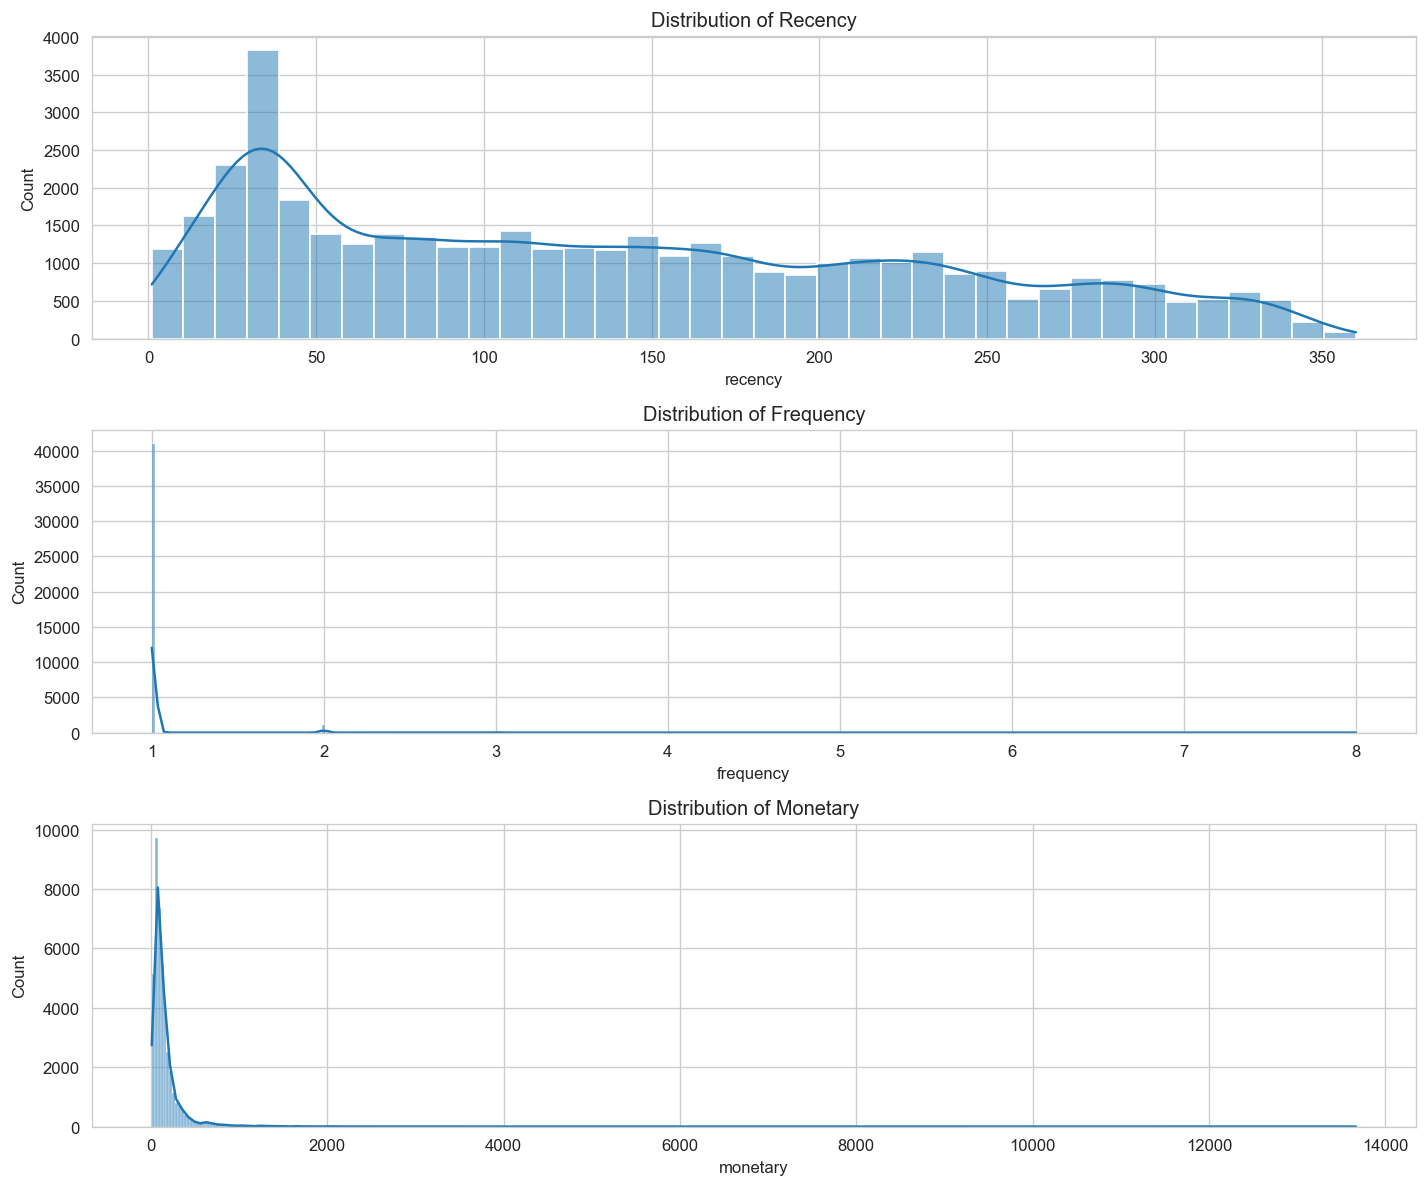

In [482]:
plt.figure(figsize=(12, 10))

plt.subplot(3, 1, 1)
sns.histplot(rfm_simple['recency'], kde=True)
plt.title('Distribution of Recency')

plt.subplot(3, 1, 2)
sns.histplot(rfm_simple['frequency'], kde=True)
plt.title('Distribution of Frequency')

plt.subplot(3, 1, 3)
sns.histplot(rfm_simple['monetary'], kde=True)
plt.title('Distribution of Monetary')

plt.tight_layout()
plt.show()


* Nhận xét về phân phối RFM:

- 1. Recency

    + Phần lớn khách hàng có recency thấp (mua gần đây), đỉnh cao nhất quanh 30–50 ngày
    + Có một số khách hàng rất lâu không mua, nhưng chiếm tỷ lệ nhỏ → khách trung thành và khách lâu không tương tác đều tồn tại

- 2. Frequency

    + Đa số khách chỉ mua 1 lần → tỉ lệ khách mua lại thấp
    + Số khách mua 2–3 lần và >3 lần giảm rất nhanh → phần lớn khách hàng chưa trở thành khách trung thành

- 3. Monetary

    + Phần lớn khách chi tiêu thấp, chỉ một số ít khách chi tiêu cao
    + Phân phối có long tail, vài khách hàng chi tiêu cực lớn

## 7.Cohort Retention

In [483]:
train_tx['order_month'] = train_tx['order_date'].dt.to_period('M')
first_month = train_tx.groupby('customer_unique_id')['order_month'].min().rename('cohort')
cohort_df = train_tx.merge(first_month, on='customer_unique_id', how='left')
cohort_df['cohort_index'] = (cohort_df['order_month'] - cohort_df['cohort']).apply(lambda p: p.n)

cohort_pivot = (
    cohort_df.groupby(['cohort', 'cohort_index'])['customer_unique_id']
    .nunique().unstack(1).fillna(0)
)
retention = cohort_pivot.divide(cohort_pivot.iloc[:,0], axis=0)


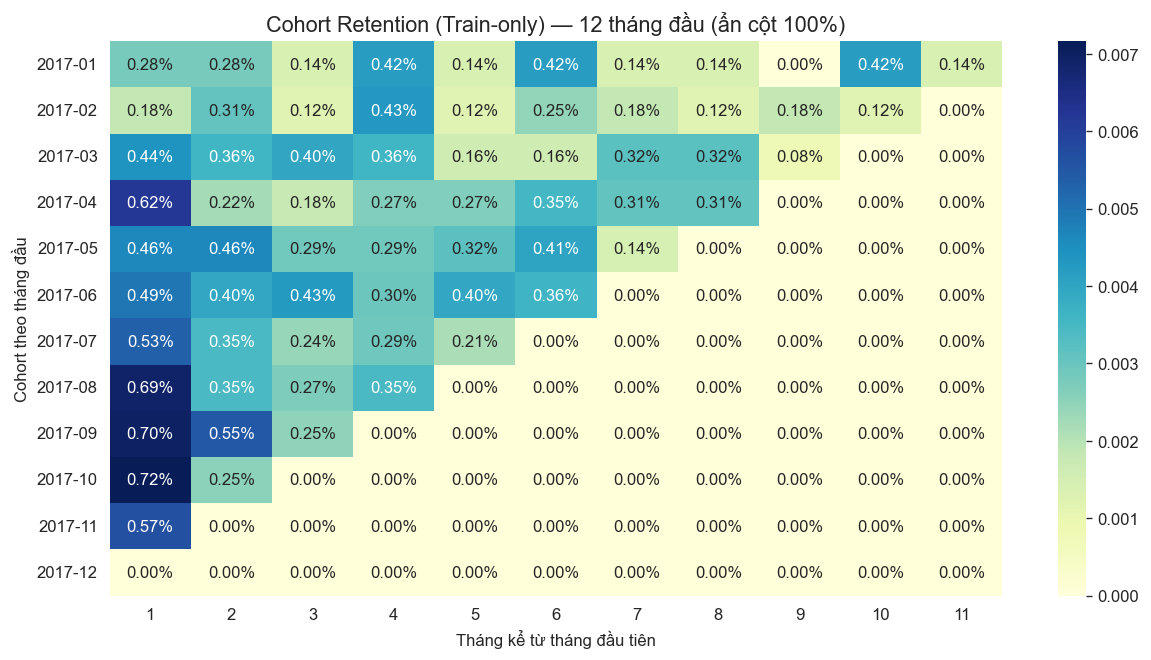

In [484]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Bỏ cột 0 (tháng đầu = 100%)
sns.heatmap(
    retention.iloc[:, 1:13],    # chỉ lấy từ tháng 1 đến tháng 12
    annot=True,
    fmt=".2%",
    cmap="YlGnBu",
    cbar=True
)

plt.title("Cohort Retention (Train-only) — 12 tháng đầu (ẩn cột 100%)", fontsize=13)
plt.ylabel("Cohort theo tháng đầu")
plt.xlabel("Tháng kể từ tháng đầu tiên")
plt.show()


* Nhận xét tổng quan:

  - Tỷ lệ quay lại nhìn chung rất thấp, chỉ dao động quanh 0.2–0.7% ở tháng kế tiếp, rồi giảm nhanh về gần 0% sau 3–4 tháng

  - Đa số cohort đều có hiện tượng “rơi rụng nhanh”, đặc biệt từ tháng thứ 4 trở đi, gần như không còn khách quay lại
  
  - Điều này cho thấy phần lớn khách hàng chỉ phát sinh một lần mua, đúng với mô tả “one-time heavy” thường thấy trong thương mại điện tử marketplace

## 8.Baseline CLV – Fit BG/NBD & Gamma–Gamma

### 8.1. Dự báo CLV

In [485]:
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import summary_data_from_transaction_data

# Tạo bảng tóm tắt hành vi mua (input cho lifetimes)
# Dữ liệu này được gọi là RFM table dành cho phân tích BG/NBD:

    #   - R (Recency): khoảng cách từ lần mua gần nhất đến cuối quan sát
    #   - F (Frequency): số lần mua sau lần đầu trong giai đoạn quan sát (đã -1 so với RFM bình thường)
    #   - M (Monetary value): giá trị trung bình mỗi đơn hàng

summary = summary_data_from_transaction_data(
    transactions=train_tx,            # DataFrame chứa dữ liệu giao dịch
    customer_id_col='customer_unique_id',  # Cột ID khách hàng
    datetime_col='order_date',        # Cột ngày giao dịch
    monetary_value_col='order_value', # Cột giá trị đơn hàng
    observation_period_end=SNAPSHOT,  # Ngày kết thúc quan sát (snapshot date)
    freq='D'                          # Đơn vị tính thời gian là ngày
).reset_index()

summary.head(5)


,customer_unique_id,frequency,recency,T,monetary_value
0,0000f46a3911fa3c0805444483337064,0.0,0.0,297.0,0.0
1,0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,81.0,0.0
2,0004aac84e0df4da2b147fca70cf8255,0.0,0.0,48.0,0.0
3,0005e1862207bf6ccc02e4228effd9a0,0.0,0.0,303.0,0.0
4,0006fdc98a402fceb4eb0ee528f6a8d4,0.0,0.0,167.0,0.0


In [486]:
summary.describe()

,frequency,recency,T,monetary_value
count,42066.000000,42066.000000,42066.000000,42066.000000
mean,0.018423,1.257857,138.985428,2.518800
std,0.150337,13.306687,95.428196,28.648989
min,0.000000,0.000000,2.000000,0.000000
25%,0.000000,0.000000,49.000000,0.000000
50%,0.000000,0.000000,125.000000,0.000000
75%,0.000000,0.000000,215.000000,0.000000
max,7.000000,313.000000,361.000000,1650.180000


- Khách hàng chủ yếu mua 1 lần duy nhất, ít khách mua nhiều lần

In [487]:
# Fit mô hình BG/NBD (tần suất mua)
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

# Fit mô hình Gamma–Gamma (chi tiêu trung bình)
mask_rep = (summary['frequency'] > 0) & (summary['monetary_value'] > 0)
ggf = GammaGammaFitter(penalizer_coef=0.001)
ggf.fit(summary.loc[mask_rep,'frequency'], summary.loc[mask_rep,'monetary_value'])

# Dự báo số lần mua và chi tiêu trong 6 tháng tới
H_days = (H_END - H_START).days + 1
summary['pred_purchases_6m'] = bgf.predict(H_days, summary['frequency'], summary['recency'], summary['T'])
summary['pred_avg_value']    = ggf.conditional_expected_average_profit(summary['frequency'], summary['monetary_value'])
summary['CLV_prob_6m']       = summary['pred_purchases_6m'] * summary['pred_avg_value']

# Xác suất còn hoạt động
summary['p_alive'] = bgf.conditional_probability_alive(summary['frequency'], summary['recency'], summary['T'])

summary.head(5)

,customer_unique_id,frequency,recency,T,monetary_value,pred_purchases_6m,pred_avg_value,CLV_prob_6m,p_alive
0,0000f46a3911fa3c0805444483337064,0.0,0.0,297.0,0.0,0.006591,280.695271,1.850148,1.0
1,0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,81.0,0.0,0.013880,280.695271,3.895925,1.0
2,0004aac84e0df4da2b147fca70cf8255,0.0,0.0,48.0,0.0,0.016867,280.695271,4.734350,1.0
3,0005e1862207bf6ccc02e4228effd9a0,0.0,0.0,303.0,0.0,0.006498,280.695271,1.823989,1.0
4,0006fdc98a402fceb4eb0ee528f6a8d4,0.0,0.0,167.0,0.0,0.009594,280.695271,2.693117,1.0


In [488]:
# In thống kê mô tả cho 3 biến chính
summary[['pred_purchases_6m', 'pred_avg_value', 'p_alive']].describe().T

,count,mean,std,min,25%,50%,75%,max
pred_purchases_6m,42066.0,0.014917,0.052763,0.005718,0.008281,0.011426,0.017093,5.098224
pred_avg_value,42066.0,278.553764,26.255819,22.907304,280.695271,280.695271,280.695271,1604.838045
p_alive,42066.0,0.985326,0.113702,0.025294,1.000000,1.000000,1.000000,1.000000


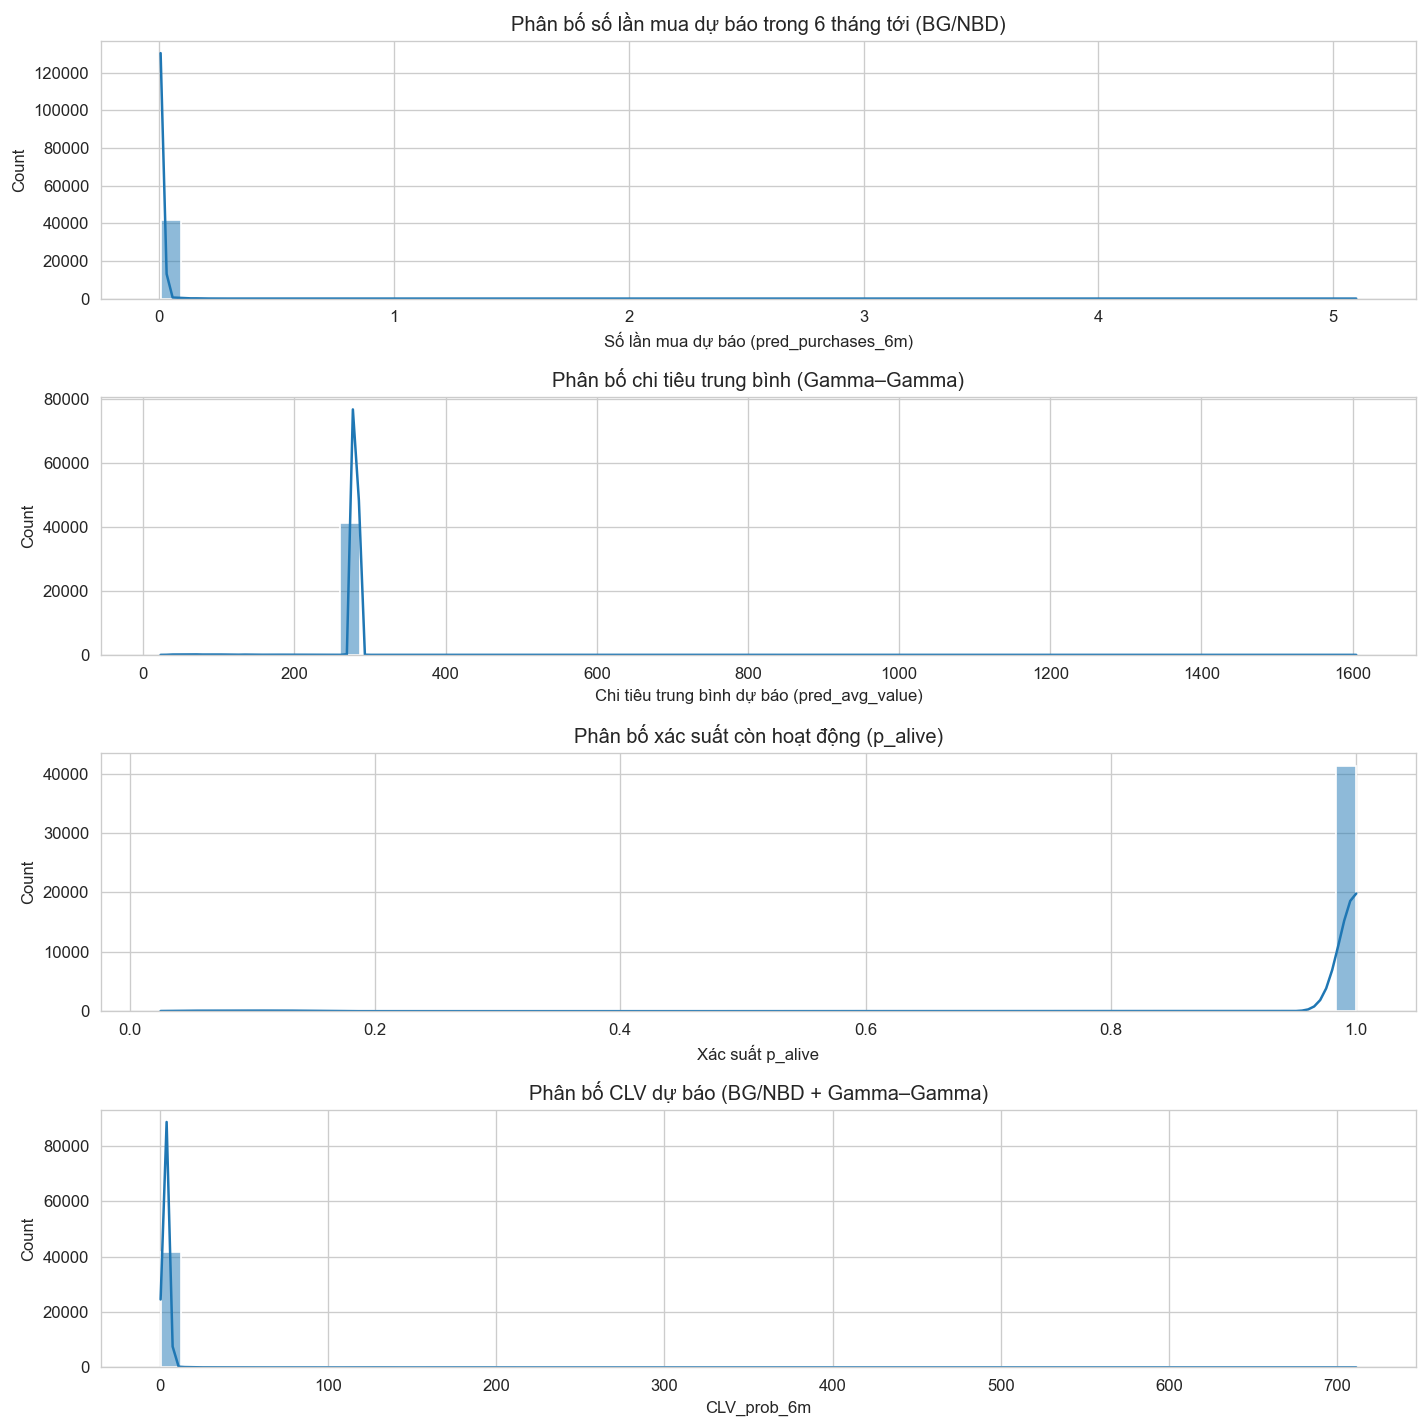

In [489]:
plt.figure(figsize=(12, 12))

plt.subplot(4, 1, 1)
sns.histplot(summary['pred_purchases_6m'], kde=True, bins=60)
plt.title('Phân bố số lần mua dự báo trong 6 tháng tới (BG/NBD)')
plt.xlabel('Số lần mua dự báo (pred_purchases_6m)')

plt.subplot(4, 1, 2)
sns.histplot(summary['pred_avg_value'], kde=True, bins=60)
plt.title('Phân bố chi tiêu trung bình (Gamma–Gamma)')
plt.xlabel('Chi tiêu trung bình dự báo (pred_avg_value)')

plt.subplot(4, 1, 3)
sns.histplot(summary['p_alive'], kde=True, bins=60)
plt.title('Phân bố xác suất còn hoạt động (p_alive)')
plt.xlabel('Xác suất p_alive')

plt.subplot(4, 1, 4)
sns.histplot(summary['CLV_prob_6m'], kde=True, bins=60)
plt.title('Phân bố CLV dự báo (BG/NBD + Gamma–Gamma)')
plt.xlabel('CLV_prob_6m')

plt.tight_layout()
plt.show()


* Nhận xét:
    - Phân bố số lần mua (pred_purchases_6m): Lệch phải nghiêm trọng. Đại đa số khách hàng được dự đoán có số lần mua tiệm cận 0 trong 6 tháng tới
    - Phân bố chi tiêu trung bình (pred_avg_value): Phân bố chuẩn, tập trung cao (high kurtosis). Cho thấy mức chi tiêu trung bình dự kiến (nếu có mua) khá đồng đều quanh mốc 300
    - Phân bố xác suất hoạt động (p_alive): Có một đỉnh (peak) rất lớn tại p_alive ≈ 1.0. Điều này cho thấy mô hình đánh giá phần lớn khách hàng vẫn đang active
    - Phân bố CLV dự báo (CLV_prob_6m): Lệch phải nghiêm trọng (tương tự Plot 1). Vì số lần mua dự kiến (Plot 1) thấp, nên CLV dự báo của đa số khách hàng cũng gần bằng 0

### 8.2. CALIBRATION DECILE
* Dùng để đánh giá độ tin cậy của toàn bộ mô hình xác suất (BG/NBD + GG)

In [490]:
from lifetimes.utils import calibration_and_holdout_data

cal_hold_df = calibration_and_holdout_data(
    transactions=trans,
    customer_id_col='customer_unique_id',
    datetime_col='order_date',
    calibration_period_end=CUTOFF,
    observation_period_end=H_END,
    freq='D'
)

In [491]:
from lifetimes import BetaGeoFitter

bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(
    frequency=cal_hold_df['frequency_cal'],
    recency=cal_hold_df['recency_cal'],
    T=cal_hold_df['T_cal']
)

<lifetimes.BetaGeoFitter: fitted with 42066 subjects, a: 0.26, alpha: 57.39, b: 0.05, r: 0.02>

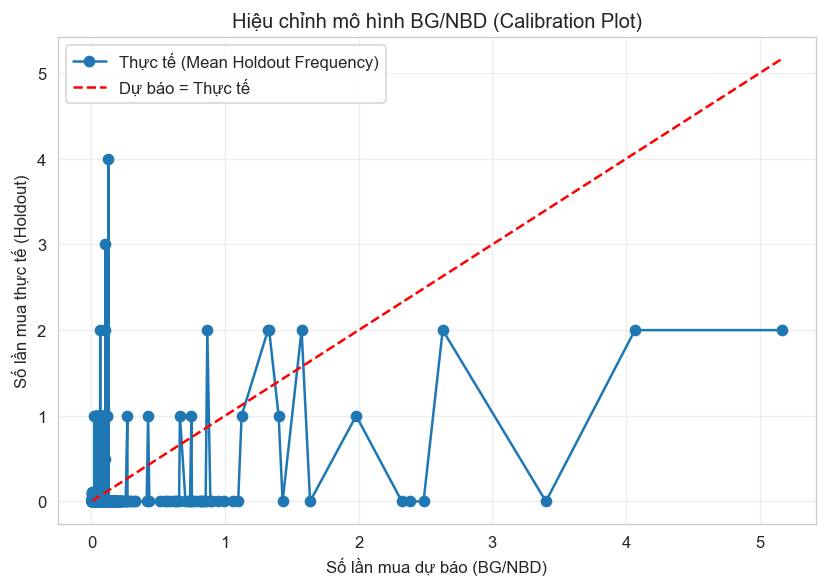

In [492]:
# Dự báo số lần mua trong giai đoạn holdout

t_holdout = cal_hold_df['duration_holdout'].iloc[0]  # số ngày holdout
cal_hold_df['pred_purchases'] = bgf.predict(
    t=t_holdout,
    frequency=cal_hold_df['frequency_cal'],
    recency=cal_hold_df['recency_cal'],
    T=cal_hold_df['T_cal']
)

# Gom theo số lần mua dự báo
grouped = cal_hold_df.groupby('pred_purchases')['frequency_holdout'].mean()

# Vẽ biểu đồ calibration
plt.figure(figsize=(7, 5))
plt.plot(grouped.index, grouped.values, "o-", label="Thực tế (Mean Holdout Frequency)")
plt.plot(grouped.index, grouped.index, "r--", label="Dự báo = Thực tế")
plt.title("Hiệu chỉnh mô hình BG/NBD (Calibration Plot)")
plt.xlabel("Số lần mua dự báo (BG/NBD)")
plt.ylabel("Số lần mua thực tế (Holdout)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## 9.Gắn nhãn CLV thực tế & tạo Feature Set

In [493]:
# Nhãn thật (chi tiêu thực tế trong Horizon) - Horizon là 6 tháng đầu của 2018
y_true = (
    test_tx.groupby('customer_unique_id')['order_value'].sum()
    .rename('CLV_actual_6m')
)
summary = summary.merge(y_true, on='customer_unique_id', how='left')
summary['CLV_actual_6m'] = summary['CLV_actual_6m'].fillna(0.0)

In [494]:
print("10 hàng đầu tiên của bảng summary với CLV_actual_6m:")
print(summary[['customer_unique_id', 'frequency', 'recency', 'T', 'CLV_actual_6m']].head(10))

print("\nThống kê mô tả (describe) của CLV_actual_6m:")
print(summary['CLV_actual_6m'].describe())

10 hàng đầu tiên của bảng summary với CLV_actual_6m:
                 customer_unique_id  frequency  recency      T  CLV_actual_6m
0  0000f46a3911fa3c0805444483337064        0.0      0.0  297.0            0.0
1  0000f6ccb0745a6a4b88665a16c9f078        0.0      0.0   81.0            0.0
2  0004aac84e0df4da2b147fca70cf8255        0.0      0.0   48.0            0.0
3  0005e1862207bf6ccc02e4228effd9a0        0.0      0.0  303.0            0.0
4  0006fdc98a402fceb4eb0ee528f6a8d4        0.0      0.0  167.0            0.0
5  00082cbe03e478190aadbea78542e933        0.0      0.0   43.0            0.0
6  000a5ad9c4601d2bbdd9ed765d5213b3        0.0      0.0  143.0            0.0
7  000bfa1d2f1a41876493be685390d6d3        0.0      0.0   94.0            0.0
8  000c8bdb58a29e7115cfc257230fb21b        0.0      0.0   20.0            0.0
9  000de6019bb59f34c099a907c151d855        0.0      0.0  137.0            0.0

Thống kê mô tả (describe) của CLV_actual_6m:
count    42066.000000
mean         2.007218

In [495]:
# Đếm số lượng CLV = 0 (kiểm tra Zero-Inflation)
zero_clv = (summary['CLV_actual_6m'] == 0).sum()
total_cust = len(summary)
print(f"\nTỷ lệ khách hàng có CLV_actual_6m = 0: {zero_clv / total_cust * 100:.2f}% ({zero_clv}/{total_cust})")


Tỷ lệ khách hàng có CLV_actual_6m = 0: 98.73% (41530/42066)


In [496]:
# Bổ sung feature hành vi mở rộng (payment/review/items)
agg_base = train_tx[['order_id','customer_unique_id','customer_state']].copy()
feat_aggs = (
    agg_base
    .merge(payments[['order_id','payment_value']], on='order_id', how='left')
    .merge(reviews[['order_id','review_score']], on='order_id', how='left')
    .merge(items[['order_id','product_id']], on='order_id', how='left')
    .groupby('customer_unique_id')
    .agg(
        payment_value_sum   = ('payment_value','sum'),
        payment_value_mean  = ('payment_value','mean'),
        review_score_mean   = ('review_score','mean'),
        num_unique_products = ('product_id', pd.Series.nunique),
        state_mode          = ('customer_state', lambda x: x.mode()[0] if len(x.mode())>0 else np.nan)
    ).reset_index()
)

# Merge features vào bảng summary
summary_ml = summary.merge(feat_aggs, on='customer_unique_id', how='left')
summary_ml.head(5)

,customer_unique_id,frequency,recency,T,monetary_value,pred_purchases_6m,pred_avg_value,CLV_prob_6m,p_alive,CLV_actual_6m,payment_value_sum,payment_value_mean,review_score_mean,num_unique_products,state_mode
0,0000f46a3911fa3c0805444483337064,0.0,0.0,297.0,0.0,0.006591,280.695271,1.850148,1.0,0.0,86.22,86.22,3.0,1,SC
1,0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,81.0,0.0,0.013880,280.695271,3.895925,1.0,0.0,43.62,43.62,4.0,1,PA
2,0004aac84e0df4da2b147fca70cf8255,0.0,0.0,48.0,0.0,0.016867,280.695271,4.734350,1.0,0.0,196.89,196.89,5.0,1,SP
3,0005e1862207bf6ccc02e4228effd9a0,0.0,0.0,303.0,0.0,0.006498,280.695271,1.823989,1.0,0.0,150.12,150.12,4.0,1,RJ
4,0006fdc98a402fceb4eb0ee528f6a8d4,0.0,0.0,167.0,0.0,0.009594,280.695271,2.693117,1.0,0.0,29.00,29.00,3.0,1,ES


In [497]:
calc_null_rate(summary_ml)

,null_count,null_rate
review_score_mean,311,0.007393
frequency,0,0.000000
customer_unique_id,0,0.000000
T,0,0.000000
monetary_value,0,0.000000
pred_purchases_6m,0,0.000000
recency,0,0.000000
pred_avg_value,0,0.000000
CLV_prob_6m,0,0.000000
CLV_actual_6m,0,0.000000


In [498]:
# Xử lý thiếu
# Chỉ còn cột 'review_score_mean' bị thiếu (~0.7% khách)
# Điền giá trị trung vị để giữ phân phối ổn định, tránh mất mẫu
median_review = summary_ml['review_score_mean'].median()
summary_ml['review_score_mean'] = summary_ml['review_score_mean'].fillna(median_review)

print("Tổng số khách hàng:", len(summary_ml))
summary_ml.head(3)

Tổng số khách hàng: 42066


,customer_unique_id,frequency,recency,T,monetary_value,pred_purchases_6m,pred_avg_value,CLV_prob_6m,p_alive,CLV_actual_6m,payment_value_sum,payment_value_mean,review_score_mean,num_unique_products,state_mode
0,0000f46a3911fa3c0805444483337064,0.0,0.0,297.0,0.0,0.006591,280.695271,1.850148,1.0,0.0,86.22,86.22,3.0,1,SC
1,0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,81.0,0.0,0.013880,280.695271,3.895925,1.0,0.0,43.62,43.62,4.0,1,PA
2,0004aac84e0df4da2b147fca70cf8255,0.0,0.0,48.0,0.0,0.016867,280.695271,4.734350,1.0,0.0,196.89,196.89,5.0,1,SP


## 10.Xây dựng Bộ tiền xử lý (Preprocessor)

In [499]:
# ================================================
# MỤC 10: XÂY DỰNG BỘ TIỀN XỬ LÝ (PREPROCESSOR)
# ================================================
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Xác định cột numeric và categorical
# (Những danh sách này sẽ được sử dụng lặp lại ở Step 11)
numeric_features = [
    'frequency','recency','T','monetary_value',
    'p_alive','CLV_prob_6m',
    'payment_value_sum','payment_value_mean',
    'review_score_mean','num_unique_products'
]
categorical_features = ['state_mode']

# Preprocessor: scale số + OneHotEncode hạng mục
# (Đây là 'linh hồn' của Step 10, nó sẽ được gọi trong TẤT CẢ các pipeline ở Step 11)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

print(f"Numeric features: {len(numeric_features)} cột")
print(f"Categorical features: {len(categorical_features)} cột")

Numeric features: 10 cột
Categorical features: 1 cột


## 11.Cross-Validation & Lựa chọn Mô hình Tốt nhất

In [500]:

# Tạo biến mục tiêu cho mô hình 2 thành phần (Two-Part)

summary_ml['y_cls'] = (summary_ml['CLV_actual_6m'] > 0).astype(int)
summary_ml_reg = summary_ml[summary_ml['y_cls'] == 1].copy()
summary_ml_reg['y_reg_log'] = np.log1p(summary_ml_reg['CLV_actual_6m'])

X_final = summary_ml[numeric_features + categorical_features].copy()
y_cls = summary_ml['y_cls'].copy()
X_reg = summary_ml_reg[numeric_features + categorical_features].copy()
y_reg_log = summary_ml_reg['y_reg_log'].copy()

# Cấu hình CV
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [501]:
print("\n" + "="*70)
print("           TỐI ƯU HÓA & ĐÁNH GIÁ: TWO-PART XGBOOST")
print("="*70)

# --- A. Tối ưu Hồi quy (Regressor) ---
pipe_reg_xgb_base = Pipeline([
    ('preprocess', preprocessor),
    ('model', XGBRegressor(random_state=42, tree_method='hist'))
])
param_grid_reg_xgb = {
    'model__n_estimators': [300, 500], 'model__max_depth': [4, 6], 'model__learning_rate': [0.05, 0.1]
}
grid_reg_xgb = GridSearchCV(
    estimator=pipe_reg_xgb_base, param_grid=param_grid_reg_xgb,
    scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1
)

grid_reg_xgb.fit(X_reg, y_reg_log)
best_reg_xgb = grid_reg_xgb.best_estimator_.named_steps['model']

# --- B. Tối ưu Phân loại (Classifier) ---
pipe_cls_xgb_base = Pipeline([
    ('preprocess', preprocessor),
    ('model', XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False))
])
param_grid_cls_xgb = {
    'model__n_estimators': [300, 500], 'model__max_depth': [4, 6], 'model__learning_rate': [0.05, 0.1]
}
grid_cls_xgb = GridSearchCV(
    estimator=pipe_cls_xgb_base, param_grid=param_grid_cls_xgb,
    scoring='roc_auc', cv=cv, n_jobs=-1
)

grid_cls_xgb.fit(X_final, y_cls)
best_cls_xgb = grid_cls_xgb.best_estimator_.named_steps['model']

# --- C. Huấn luyện Final & Đánh giá ---
# (Phần này giữ nguyên, nó sử dụng các biến best_reg_xgb và best_cls_xgb ở trên)
pipe_cls_xgb = Pipeline([('preprocess', preprocessor), ('model', best_cls_xgb)]).fit(X_final, y_cls)
fitted_preprocessor = pipe_cls_xgb.named_steps['preprocess']
X_reg_transformed = fitted_preprocessor.transform(X_reg)
best_reg_xgb.fit(X_reg_transformed, y_reg_log)

# Dự đoán (P * E)
P_buy_again = pipe_cls_xgb.predict_proba(X_final)[:, 1]
X_final_transformed = fitted_preprocessor.transform(X_final)
pred_reg_log = best_reg_xgb.predict(X_final_transformed)
E_CLV_given_buy_clipped = np.maximum(np.expm1(pred_reg_log), 0)
y_pred_final_two_part = P_buy_again * E_CLV_given_buy_clipped


# ==========================================================
# KẾT QUẢ TỐI ƯU HÓA (TỪ GridSearchCV)
# ==========================================================

# === (BỔ SUNG) IN KẾT QUẢ GIAI ĐOẠN 2 (REGRESSOR) ===
print("\n KẾT QUẢ TỐI ƯU GIAI ĐOẠN 2 (XGBoost Regressor)")
print(f"   - Best Params (Regressor): {grid_reg_xgb.best_params_}")
print(f"   - Best MAE (Mean, on Log): {-grid_reg_xgb.best_score_:.4f}")
best_index_reg = grid_reg_xgb.best_index_
best_std_reg = grid_reg_xgb.cv_results_['std_test_score'][best_index_reg]
print(f"   - Best MAE (Std, on Log): {best_std_reg:.4f}")
# === KẾT THÚC BỔ SUNG ===


# KẾT QUẢ GIAI ĐOẠN 1 (CLASSIFICATION)
y_prob_cls = pipe_cls_xgb.predict_proba(X_final)[:, 1]
y_pred_cls = pipe_cls_xgb.predict(X_final)
print("\n KẾT QUẢ GIAI ĐOẠN 1: PHÂN LOẠI KHÁCH HÀNG (XGBoost Classifier)")
print(f"   - Best Params (Classifier): {grid_cls_xgb.best_params_}")
print(f"   - AUC: {roc_auc_score(y_cls, y_prob_cls):.4f}")
print(f"   - Accuracy: {accuracy_score(y_cls, y_pred_cls):.4f}")
print(f"   - Precision: {precision_score(y_cls, y_pred_cls, zero_division=0):.4f}")
print(f"   - Recall: {recall_score(y_cls, y_pred_cls, zero_division=0):.4f}")


# KẾT QUẢ GIAI ĐOẠN 2 & FINAL (REGRESSION)
y_actual_final = summary_ml['CLV_actual_6m'].astype(float)
mae_final_tp  = mean_absolute_error(y_actual_final, y_pred_final_two_part)
rmse_final_tp = np.sqrt(mean_squared_error(y_actual_final, y_pred_final_two_part))
r2_final_tp   = r2_score(y_actual_final, y_pred_final_two_part)

print("\n KẾT QUẢ GIAI ĐOẠN 2 & FINAL (Two-Part XGBoost)")
print(f"   - MAE: {mae_final_tp:.3f}")
print(f"   - RMSE: {rmse_final_tp:.3f}")
print(f"   - R²: {r2_final_tp:.3f}")
print("==========================================================")


           TỐI ƯU HÓA & ĐÁNH GIÁ: TWO-PART XGBOOST

 KẾT QUẢ TỐI ƯU GIAI ĐOẠN 2 (XGBoost Regressor)
   - Best Params (Regressor): {'model__learning_rate': 0.05, 'model__max_depth': 4, 'model__n_estimators': 300}
   - Best MAE (Mean, on Log): 0.6322
   - Best MAE (Std, on Log): 0.0361

 KẾT QUẢ GIAI ĐOẠN 1: PHÂN LOẠI KHÁCH HÀNG (XGBoost Classifier)
   - Best Params (Classifier): {'model__learning_rate': 0.1, 'model__max_depth': 4, 'model__n_estimators': 300}
   - AUC: 0.8744
   - Accuracy: 0.9880
   - Precision: 1.0000
   - Recall: 0.0597

 KẾT QUẢ GIAI ĐOẠN 2 & FINAL (Two-Part XGBoost)
   - MAE: 3.250
   - RMSE: 23.477
   - R²: 0.129


In [502]:
print("\n" + "="*70)
print("           TỐI ƯU HÓA & ĐÁNH GIÁ: TWO-PART RANDOM FOREST")
print("="*70)

# --- A. Tối ưu Hồi quy (Regressor) ---
pipe_reg_rf_base = Pipeline([
    ('preprocess', preprocessor),
    ('model', RandomForestRegressor(random_state=42, n_jobs=-1))
])
param_grid_reg_rf = {
    'model__n_estimators': [200, 400], 'model__max_depth': [8, 12]
}
grid_reg_rf = GridSearchCV(
    estimator=pipe_reg_rf_base, param_grid=param_grid_reg_rf,
    scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1
)

grid_reg_rf.fit(X_reg, y_reg_log)
best_reg_rf = grid_reg_rf.best_estimator_.named_steps['model']

# --- B. Tối ưu Phân loại (Classifier) ---
pipe_cls_rf_base = Pipeline([
    ('preprocess', preprocessor),
    ('model', RandomForestClassifier(random_state=42, n_jobs=-1))
])
param_grid_cls_rf = {
    'model__n_estimators': [200, 400], 'model__max_depth': [8, 12]
}
grid_cls_rf = GridSearchCV(
    estimator=pipe_cls_rf_base, param_grid=param_grid_cls_rf,
    scoring='roc_auc', cv=cv, n_jobs=-1
)

grid_cls_rf.fit(X_final, y_cls)
best_cls_rf = grid_cls_rf.best_estimator_.named_steps['model']

# --- C. Huấn luyện Final & Đánh giá ---
pipe_cls_rf = Pipeline([('preprocess', preprocessor), ('model', best_cls_rf)]).fit(X_final, y_cls)
fitted_preprocessor_rf = pipe_cls_rf.named_steps['preprocess']
X_reg_transformed_rf = fitted_preprocessor_rf.transform(X_reg)
best_reg_rf.fit(X_reg_transformed_rf, y_reg_log)

# Dự đoán (P * E)
P_buy_again_rf = pipe_cls_rf.predict_proba(X_final)[:, 1]
X_final_transformed_rf = fitted_preprocessor_rf.transform(X_final)
pred_reg_log_rf = best_reg_rf.predict(X_final_transformed_rf)
E_CLV_given_buy_rf_clipped = np.maximum(np.expm1(pred_reg_log_rf), 0)
CLV_pred_two_part_rf = P_buy_again_rf * E_CLV_given_buy_rf_clipped


# ==========================================================
# KẾT QUẢ TỐI ƯU HÓA (TỪ GridSearchCV)
# ==========================================================

# === (BỔ SUNG) IN KẾT QUẢ GIAI ĐOẠN 2 (REGRESSOR) ===
print("\n KẾT QUẢ TỐI ƯU GIAI ĐOẠN 2 (Random Forest Regressor)")
print(f"   - Best Params (Regressor): {grid_reg_rf.best_params_}")
print(f"   - Best MAE (Mean, on Log): {-grid_reg_rf.best_score_:.4f}")
best_index_reg_rf = grid_reg_rf.best_index_
best_std_reg_rf = grid_reg_rf.cv_results_['std_test_score'][best_index_reg_rf]
print(f"   - Best MAE (Std, on Log): {best_std_reg_rf:.4f}")
# === KẾT THÚC BỔ SUNG ===


# KẾT QUẢ GIAI ĐOẠN 1 (CLASSIFICATION)
y_prob_cls_rf = pipe_cls_rf.predict_proba(X_final)[:, 1]
y_pred_cls_rf = pipe_cls_rf.predict(X_final)
print("\n KẾT QUẢ GIAI ĐOẠN 1: PHÂN LOẠI KHÁCH HÀNG (Random Forest Classifier)")
print(f"   - Best Params (Classifier): {grid_cls_rf.best_params_}")
print(f"   - AUC: {roc_auc_score(y_cls, y_prob_cls_rf):.4f}")
print(f"   - Accuracy: {accuracy_score(y_cls, y_pred_cls_rf):.4f}")
print(f"   - Precision: {precision_score(y_cls, y_pred_cls_rf, zero_division=0):.4f}")
print(f"   - Recall: {recall_score(y_cls, y_pred_cls_rf, zero_division=0):.4f}")


# KẾT QUẢ GIAI ĐOẠN 2 & FINAL (REGRESSION)
# (y_actual_final đã được định nghĩa ở cell XGBoost)
mae_final_tp_rf  = mean_absolute_error(y_actual_final, CLV_pred_two_part_rf)
rmse_final_tp_rf = np.sqrt(mean_squared_error(y_actual_final, CLV_pred_two_part_rf))
r2_final_tp_rf   = r2_score(y_actual_final, CLV_pred_two_part_rf)

print("\n KẾT QUẢ GIAI ĐOẠN 2 & FINAL (Two-Part Random Forest)")
print(f"   - MAE: {mae_final_tp_rf:.3f}")
print(f"   - RMSE: {rmse_final_tp_rf:.3f}")
print(f"   - R²: {r2_final_tp_rf:.3f}")
print("==========================================================")


           TỐI ƯU HÓA & ĐÁNH GIÁ: TWO-PART RANDOM FOREST



 KẾT QUẢ TỐI ƯU GIAI ĐOẠN 2 (Random Forest Regressor)
   - Best Params (Regressor): {'model__max_depth': 8, 'model__n_estimators': 200}
   - Best MAE (Mean, on Log): 0.6032
   - Best MAE (Std, on Log): 0.0149

 KẾT QUẢ GIAI ĐOẠN 1: PHÂN LOẠI KHÁCH HÀNG (Random Forest Classifier)
   - Best Params (Classifier): {'model__max_depth': 8, 'model__n_estimators': 400}
   - AUC: 0.8751
   - Accuracy: 0.9875
   - Precision: 1.0000
   - Recall: 0.0224

 KẾT QUẢ GIAI ĐOẠN 2 & FINAL (Two-Part Random Forest)
   - MAE: 3.316
   - RMSE: 24.440
   - R²: 0.056


## 12.Huấn luyện mô hình TWO-PART XGBOOST Final

In [503]:
import joblib

# --- Lấy lại preprocessor & cấu hình model TWO-PART XGBOOST tốt nhất ---

BEST_CLF_PARAMS = {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300}
BEST_REG_PARAMS = {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 300}

# KHỞI TẠO MÔ HÌNH FINAL (Classifier & Regressor)

# 1. Classifier Model (Phần 1) - Nằm trong Pipeline
xgb_cls_final = XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False,
    **BEST_CLF_PARAMS
)
pipe_cls_xgb = Pipeline([
    ('preprocess', preprocessor),
    ('model', xgb_cls_final)
])

# 2. Regressor Model (Phần 2) - Chỉ mô hình
xgb_reg_final = XGBRegressor(
    random_state=42,
    tree_method='hist',
    **BEST_REG_PARAMS
)


# HUẤN LUYỆN MÔ HÌNH (Áp dụng Two-Part Fix)

# 1. Huấn luyện Classifier (Fit trên X_final để lấy Fitted Preprocessor)

pipe_cls_xgb.fit(X_final, y_cls)

# 2. Lấy preprocessor đã fit
fitted_preprocessor = pipe_cls_xgb.named_steps['preprocess']

# 3. Huấn luyện Regressor (Fit trên X_reg đã được transform)
X_reg_transformed = fitted_preprocessor.transform(X_reg)
xgb_reg_final.fit(X_reg_transformed, y_reg_log)

#  Lưu pipeline (Classifier) và model (Regressor) đã huấn luyện
joblib.dump(pipe_cls_xgb, 'clv_pipeline_cls_xgb.joblib')
joblib.dump(xgb_reg_final, 'clv_model_reg_xgb.joblib')


['clv_model_reg_xgb.joblib']

## 13.Dự báo CLV Final & Đánh giá

In [504]:
# A. DỰ BÁO CLV BẰNG MÔ HÌNH TWO-PART (P * E)

# 1. Dự đoán P(Mua lại) - (Sử dụng Classifier Pipeline)
P_buy_again = pipe_cls_xgb.predict_proba(X_final)[:, 1]

# 2. Biến đổi X_final bằng preprocessor đã fit
X_final_transformed = fitted_preprocessor.transform(X_final)

# 3. Dự đoán E(CLV | Mua lại) - (Sử dụng Regressor Model)
pred_reg_log = xgb_reg_final.predict(X_final_transformed)

# 4. Trả về thang đo gốc và tính CLV Final
E_CLV_given_buy_clipped = np.maximum(np.expm1(pred_reg_log), 0)
y_pred_final = P_buy_again * E_CLV_given_buy_clipped

# B. TÍNH TOÁN CHỈ SỐ LỖI (Metrics)


# Lấy nhãn thật (y_true) từ summary_ml
y_actual_final = summary_ml['CLV_actual_6m'].astype(float)

# Tính sai số & R²
mae_final  = mean_absolute_error(y_actual_final, y_pred_final)
rmse_final = np.sqrt(mean_squared_error(y_actual_final, y_pred_final))
r2_final   = r2_score(y_actual_final, y_pred_final)

print("\n=== KẾT QUẢ MÔ HÌNH TWO-PART XGBOOST FINAL ===")
print(f"MAE = {mae_final:.3f}")
print(f"RMSE = {rmse_final:.3f}")
print(f"R² = {r2_final:.3f}")


=== KẾT QUẢ MÔ HÌNH TWO-PART XGBOOST FINAL ===
MAE = 3.250
RMSE = 23.477
R² = 0.129


In [505]:
print("--- So sánh Hiệu suất Mô hình (MAE, RMSE & R²) ---")

# Lấy dữ liệu dự đoán từ các bước trước
y_pred_baseline = summary_ml['CLV_prob_6m'].copy()

# Tính toán Metrics cho Baseline (BG/NBD + GG)
mae_baseline = mean_absolute_error(y_actual_final, y_pred_baseline)
rmse_baseline = np.sqrt(mean_squared_error(y_actual_final, y_pred_baseline))
r2_baseline = r2_score(y_actual_final, y_pred_baseline)

# So sánh
comparison_df = pd.DataFrame({
    'Model': ['Baseline (BG/NBD+GG)', 'Two-Part (XGBoost)'],
    'MAE': [mae_baseline, mae_final],
    'RMSE': [rmse_baseline, rmse_final],
    'R²': [r2_baseline, r2_final]
})

comparison_df = comparison_df.set_index('Model')
print(comparison_df)

--- So sánh Hiệu suất Mô hình (MAE, RMSE & R²) ---
                           MAE       RMSE        R²
Model                                              
Baseline (BG/NBD+GG)  5.678696  26.021917 -0.070515
Two-Part (XGBoost)    3.249927  23.476781  0.128653


* Nhận xét: Mô hình Two-Part (XGBoost) trội hơn hẳn so với mô hình Baseline (BG/NBD+GG) ở cả ba chỉ số

## 14.Phân tích tầm quan trọng đặc trưng (Feature Importance)

In [506]:
num_names = numeric_features
cat_names = list(
    pipe_cls_xgb.named_steps['preprocess'] 
    .named_transformers_['cat']
    .get_feature_names_out(categorical_features)
)
all_feature_names = num_names + cat_names

feature_importance = xgb_reg_final.feature_importances_ 

# --- Tạo bảng importance ---
imp_df = pd.Series(feature_importance, index=all_feature_names).sort_values(ascending=False)
imp_df.head(15)

state_mode_RJ          0.084246
payment_value_sum      0.052021
review_score_mean      0.051440
payment_value_mean     0.050844
state_mode_MG          0.047968
CLV_prob_6m            0.047418
state_mode_BA          0.046747
state_mode_SP          0.046723
state_mode_PA          0.045850
state_mode_PR          0.045608
state_mode_RS          0.044399
num_unique_products    0.043810
state_mode_SE          0.042521
p_alive                0.041532
recency                0.039811
dtype: float32

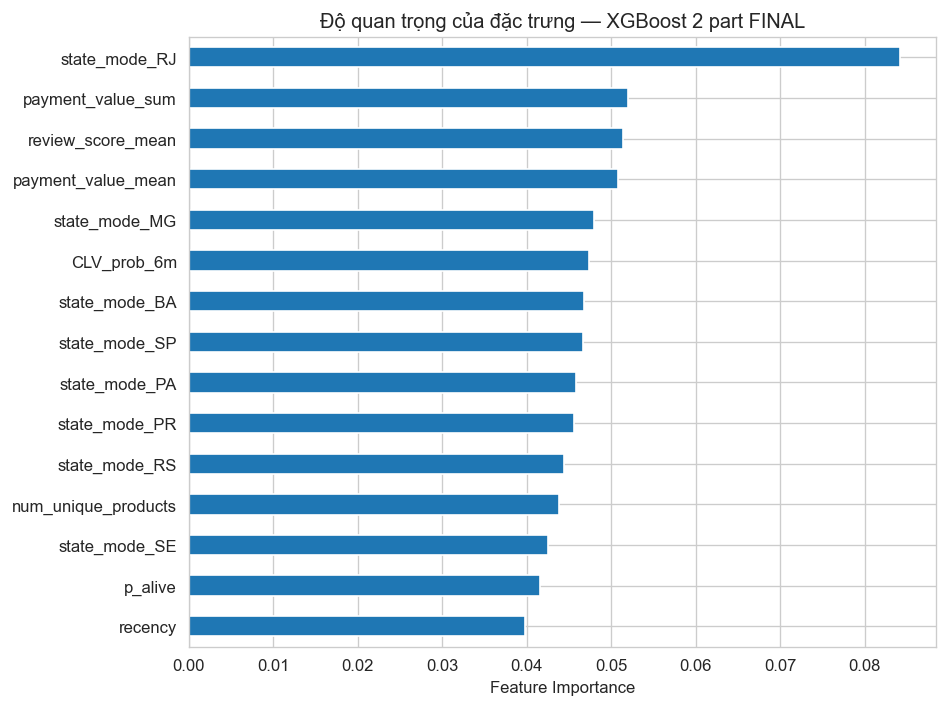

In [507]:
plt.figure(figsize=(8,6))

imp_df.head(15).sort_values(ascending=True).plot(kind='barh') 
plt.title("Độ quan trọng của đặc trưng — XGBoost 2 part FINAL")
plt.xlabel("Feature Importance")
plt.tight_layout()
plt.show()


--- Feature Importance cho Classifier (Phần 1: Dự đoán P(Mua lại)) ---


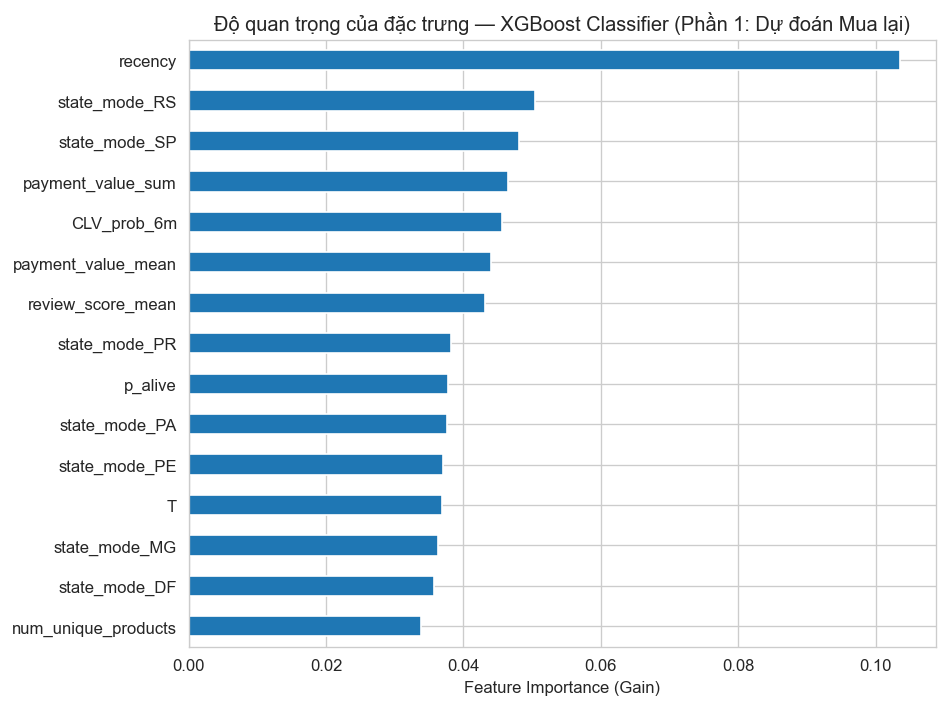


Top 15 Features quan trọng nhất để dự đoán P(Mua lại):
recency                0.103590
state_mode_RS          0.050385
state_mode_SP          0.048118
payment_value_sum      0.046425
CLV_prob_6m            0.045547
payment_value_mean     0.043937
review_score_mean      0.043178
state_mode_PR          0.038110
p_alive                0.037811
state_mode_PA          0.037592
state_mode_PE          0.037077
T                      0.036832
state_mode_MG          0.036259
state_mode_DF          0.035762
num_unique_products    0.033828
dtype: float32


In [508]:
print("\n--- Feature Importance cho Classifier (Phần 1: Dự đoán P(Mua lại)) ---")

# 1. Lấy tên feature từ preprocessor 
try:
    num_names_cls = numeric_features
    cat_names_cls = list(
        pipe_cls_xgb.named_steps['preprocess']
        .named_transformers_['cat']
        .get_feature_names_out(categorical_features)
    )
    all_feature_names_cls = num_names_cls + cat_names_cls
except Exception as e:
    print(f"Lỗi khi lấy tên feature: {e}")
    all_feature_names_cls = all_feature_names

# 2. Lấy mô hình classifier đã fit từ pipeline 
xgb_cls_model = pipe_cls_xgb.named_steps['model']

# 3. Lấy feature importance
feature_importance_cls = xgb_cls_model.feature_importances_

# 4. Tạo DataFrame và sắp xếp
imp_df_cls = pd.Series(feature_importance_cls, index=all_feature_names_cls).sort_values(ascending=False)

# 5. Vẽ biểu đồ
plt.figure(figsize=(8, 6))
imp_df_cls.head(15).sort_values(ascending=True).plot(kind='barh') # Top 15
plt.title("Độ quan trọng của đặc trưng — XGBoost Classifier (Phần 1: Dự đoán Mua lại)")
plt.xlabel("Feature Importance (Gain)")
plt.tight_layout()
plt.show()

print("\nTop 15 Features quan trọng nhất để dự đoán P(Mua lại):")
print(imp_df_cls.head(15))

## 15.So sánh thực tế vs dự báo & Phân khúc khách hàng

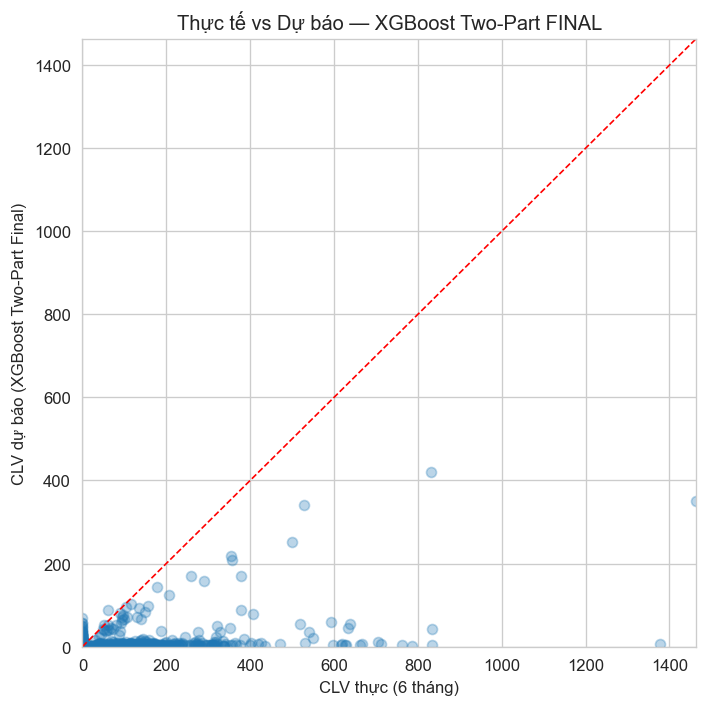

,count,mean,sum
Segment,,,
Low,13882,0.486625,6755.327148
Mid,13881,1.111843,15433.487305
High,14303,3.034466,43401.972656


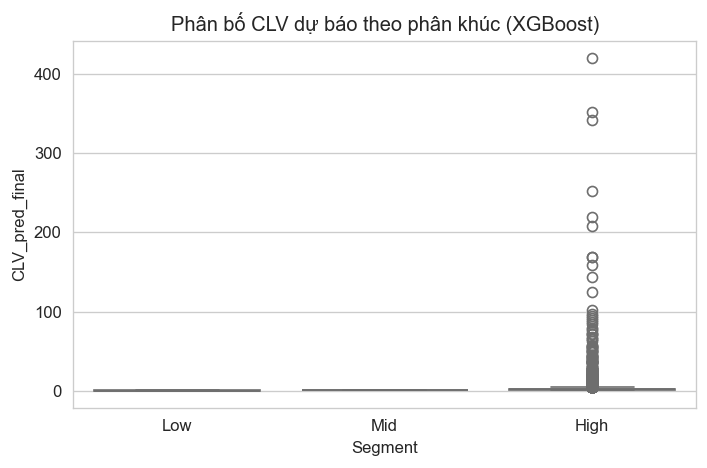

In [509]:
summary_ml['CLV_pred_final'] = np.maximum(y_pred_final, 0)

# --- VẼ SCATTER (THỰC TẾ vs DỰ BÁO) ---
plt.figure(figsize=(6,6))

plt.scatter(y_actual_final, y_pred_final, alpha=0.3) 
lim = [0, max(y_actual_final.max(), y_pred_final.max())]
plt.plot(lim, lim, 'r--', linewidth=1)
plt.xlim(lim); plt.ylim(lim)
plt.xlabel('CLV thực (6 tháng)')
plt.ylabel('CLV dự báo (XGBoost Two-Part Final)') 
plt.title('Thực tế vs Dự báo — XGBoost Two-Part FINAL') 
plt.tight_layout(); plt.show()

# --- PHÂN KHÚC THEO QUANTILE 33/66 ---
q33, q66 = np.quantile(summary_ml['CLV_pred_final'], [0.33, 0.66])

def seg(v):
    if v <= q33: return 'Low'
    elif v <= q66: return 'Mid'
    else: return 'High'

summary_ml['Segment'] = summary_ml['CLV_pred_final'].apply(seg)

# Thống kê từng phân khúc
seg_stats = summary_ml.groupby('Segment')['CLV_pred_final'].agg(['count','mean','sum']).sort_values('mean')
display(seg_stats)

# Boxplot CLV theo phân khúc
plt.figure(figsize=(6,4))
sns.boxplot(x='Segment', y='CLV_pred_final', data=summary_ml, palette='coolwarm', order=['Low', 'Mid', 'High'])
plt.title('Phân bố CLV dự báo theo phân khúc (XGBoost)')
plt.tight_layout(); plt.show()

## 16.Xuất CSV kết quả - 3 outputs

In [510]:
import os

# --- Lưu output ---
OUT_DIR = './clv_outputs_final_xgb' 
os.makedirs(OUT_DIR, exist_ok=True)


# 1. Lưu dự đoán chi tiết
out_pred = summary_ml[['customer_unique_id','p_alive','CLV_prob_6m',
                       'CLV_actual_6m','CLV_pred_final','Segment']]
out_pred.to_csv(f'{OUT_DIR}/customer_clv_predictions_xgb.csv', index=False)

# 2. Lưu thống kê phân khúc
seg_stats.to_csv(f'{OUT_DIR}/segment_stats_xgb.csv')

# 3. Lưu tầm quan trọng đặc trưng
imp_df.sort_values(ascending=False).to_csv(f'{OUT_DIR}/xgb_feature_importance.csv')

print("Đã lưu vào thư mục:", OUT_DIR)

Đã lưu vào thư mục: ./clv_outputs_final_xgb


# Phần 2: Đưa ra Insights (dựa theo số liệu và biểu đồ)

## 17. Phân tích Pareto (Two-Part XGBoost)

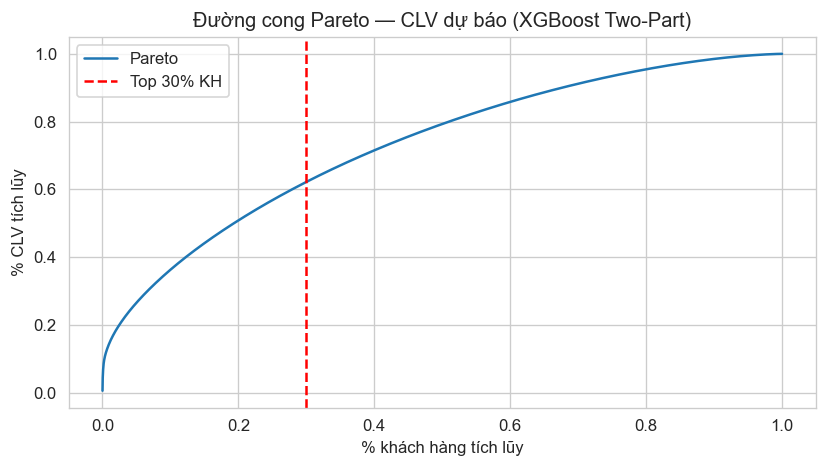

In [511]:
# Sắp xếp và tính toán % tích lũy
srt = summary_ml.sort_values('CLV_pred_final', ascending=False).reset_index(drop=True)
srt['cum_customers'] = (np.arange(len(srt)) + 1) / len(srt)
srt['cum_value'] = srt['CLV_pred_final'].cumsum() / srt['CLV_pred_final'].sum()

# Vẽ biểu đồ
plt.figure(figsize=(7,4))
plt.plot(srt['cum_customers'], srt['cum_value'], label='Pareto')
plt.axvline(0.3, color='r', linestyle='--', label='Top 30% KH')
plt.title('Đường cong Pareto — CLV dự báo (XGBoost Two-Part)')
plt.xlabel('% khách hàng tích lũy')
plt.ylabel('% CLV tích lũy')
plt.legend(); plt.tight_layout(); plt.show()

## 18. Top 10 Khách hàng có CLV cao nhất

In [512]:
# Top 10 khách hàng có CLV cao nhất
top10 = summary_ml.sort_values('CLV_pred_final', ascending=False).head(10)
print("--- Top 10 Khách hàng có CLV dự báo cao nhất (XGBoost) ---")
display(top10[['customer_unique_id','CLV_pred_final','Segment']])

--- Top 10 Khách hàng có CLV dự báo cao nhất (XGBoost) ---


,customer_unique_id,CLV_pred_final,Segment
4911,1da09dd64e235e7c2f29a4faff33535c,420.231720,High
41807,fe81bb32c243a86b2f86fbf053fe6140,351.423523,High
10244,3e43e6105506432c953e165fb2acf44c,341.450989,High
24996,9832ae2f7d3e5fa4c7a1a06e9551bc61,251.639755,High
4523,1b6c7548a2a1f9037c1fd3ddfed95f33,218.843582,High
28403,acea6bd29b8c1e3c6a8b266a8fb4475e,208.293747,High
19031,738ffcf1017b584e9d2684b36e07469c,169.170654,High
11431,455c17b35969ca198c17f2fc9e8eba1b,168.811951,High
15628,5e8f38a9a1c023f3db718edcf926a2db,158.899963,High
16559,6469f99c1f9dfae7733b25662e7f1782,143.642014,High


## 19. Phân tích Biểu đồ Phân khúc (Two-Part XGBoost)

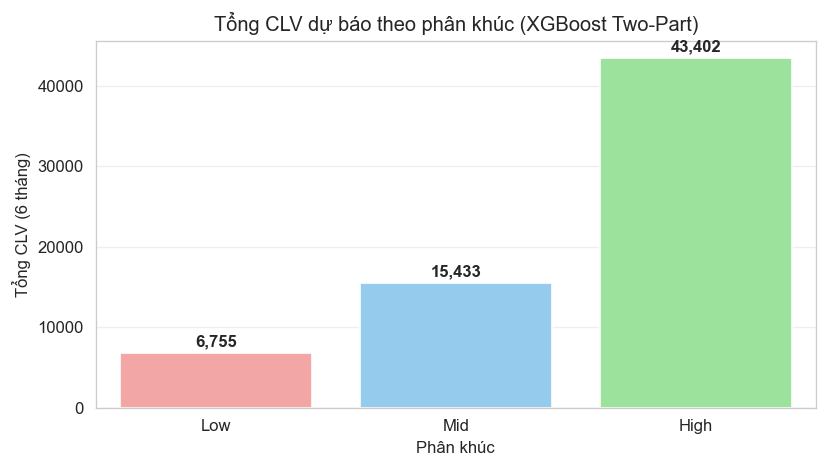

In [513]:
# --- Bar chart tổng CLV theo phân khúc ---
plt.figure(figsize=(7,4))
sns.barplot(x=seg_stats.index, y='sum', data=seg_stats.reset_index(),
            palette=['#FF9999', '#87CEFA', '#90EE90'], order=['Low', 'Mid', 'High']) 
plt.title('Tổng CLV dự báo theo phân khúc (XGBoost Two-Part)') 
plt.ylabel('Tổng CLV (6 tháng)')
plt.xlabel('Phân khúc')

seg_stats_ordered = seg_stats.loc[['Low', 'Mid', 'High']] 
for i, v in enumerate(seg_stats_ordered['sum']): 
    plt.text(i, v + seg_stats_ordered['sum'].max()*0.02, f"{v:,.0f}", ha='center', fontsize=10, fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

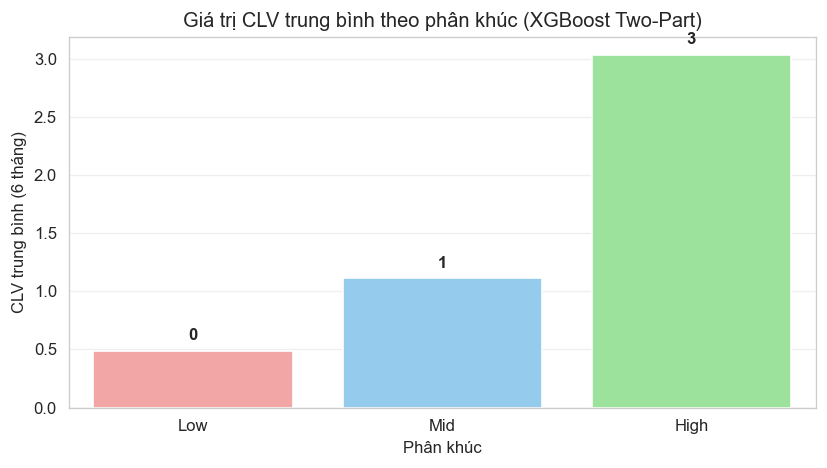

In [514]:
# --- Bar chart trung bình CLV theo phân khúc ---
plt.figure(figsize=(7,4))
sns.barplot(x=seg_stats.index, y='mean', data=seg_stats.reset_index(),
            palette=['#FF9999', '#87CEFA', '#90EE90'], order=['Low', 'Mid', 'High']) 
plt.title('Giá trị CLV trung bình theo phân khúc (XGBoost Two-Part)') 
plt.ylabel('CLV trung bình (6 tháng)')
plt.xlabel('Phân khúc')

seg_stats_ordered = seg_stats.loc[['Low', 'Mid', 'High']]
for i, v in enumerate(seg_stats_ordered['mean']):
    plt.text(i, v + seg_stats_ordered['mean'].max()*0.03, f"{v:,.0f}", ha='center', fontsize=10, fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

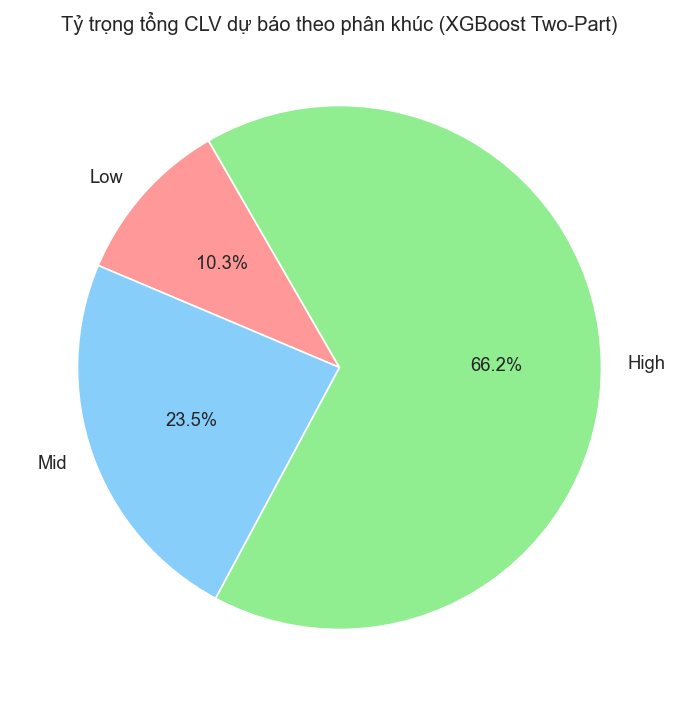

In [515]:
# --- Pie chart thể hiện tỉ trọng tổng CLV ---
plt.figure(figsize=(6,6))
colors = ['#FF9999', '#87CEFA', '#90EE90']
plt.pie(seg_stats['sum'], labels=seg_stats.index, autopct='%1.1f%%',
        startangle=120, colors=colors, textprops={'fontsize':11})
plt.title('Tỷ trọng tổng CLV dự báo theo phân khúc (XGBoost Two-Part)')
plt.tight_layout()
plt.show()

In [516]:
out_pred = pd.read_csv(f"{OUT_DIR}/customer_clv_predictions_xgb.csv") 

# Tính toán Pareto
clv = out_pred["CLV_pred_final"].clip(lower=0)
out_pred = out_pred.assign(_clv=clv).sort_values("_clv", ascending=False).reset_index(drop=True)
out_pred["cum_cust_pct"] = (np.arange(len(out_pred)) + 1) / len(out_pred)
out_pred["cum_clv"] = out_pred["_clv"].cumsum()
total_clv = out_pred["_clv"].sum()
out_pred["cum_clv_pct"] = out_pred["cum_clv"] / total_clv

# In ra các mốc % CLV
print("--- Báo cáo Phân bổ Pareto (XGBoost Two-Part) ---")
for t in [0.5, 0.7, 0.8, 0.9]:
    try:
        share = out_pred.loc[out_pred["cum_clv_pct"] >= t, "cum_cust_pct"].iloc[0]
        print(f"{int(t*100)}% tổng CLV đạt được bởi {share:.1%} khách hàng")
    except IndexError:
        print(f"Không đạt được mốc {int(t*100)}% CLV.")

--- Báo cáo Phân bổ Pareto (XGBoost Two-Part) ---
50% tổng CLV đạt được bởi 19.3% khách hàng
70% tổng CLV đạt được bởi 38.2% khách hàng
80% tổng CLV đạt được bởi 51.0% khách hàng
90% tổng CLV đạt được bởi 67.6% khách hàng


In [517]:
seg_stats_table = pd.read_csv(f"{OUT_DIR}/segment_stats_xgb.csv")
seg_stats_table.rename(columns=str.lower, inplace=True)

# Tính tỷ lệ KH và CLV
seg_stats_table["share_customers"] = seg_stats_table["count"] / seg_stats_table["count"].sum()
seg_stats_table["share_clv"] = seg_stats_table["sum"] / seg_stats_table["sum"].sum()

# Làm tròn & định dạng bảng
seg_stats_table["share_customers_fmt"] = (seg_stats_table["share_customers"]*100).round(0).astype(int).astype(str).radd("~").add("%")
seg_stats_table["share_clv_fmt"] = (seg_stats_table["share_clv"]*100).round(0).astype(int).astype(str).radd("~").add("%")
table = seg_stats_table[["segment", "share_customers_fmt", "share_clv_fmt"]]
table.columns = ["Phân khúc", "Tỷ lệ khách hàng", "Tỷ lệ CLV"]

print("\n Phân khúc khách hàng theo CLV (XGBoost Two-Part):")
print(table.to_string(index=False))


 Phân khúc khách hàng theo CLV (XGBoost Two-Part):
Phân khúc Tỷ lệ khách hàng Tỷ lệ CLV
      Low             ~33%      ~10%
      Mid             ~33%      ~24%
     High             ~34%      ~66%


In [518]:
n_customers = len(out_pred)
mean_clv = out_pred["_clv"].mean()
median_clv = out_pred["_clv"].median()
p95_clv = out_pred["_clv"].quantile(0.95)
try:
    share_80pct = out_pred.loc[out_pred["cum_clv_pct"] >= 0.8, "cum_cust_pct"].iloc[0]
    share_80_text = f"- Top {share_80pct*100:.1f}% khách hàng nắm giữ 80% tổng CLV dự báo."
except IndexError:
    share_80_text = "- (Không đạt mốc 80% CLV)"


print("\n Insight mô hình CLV (XGBoost Two-Part):") 
print(f"- Số khách hàng: {n_customers:,}")
print(f"- CLV trung bình: {mean_clv:,.2f}")
print(f"- CLV trung vị: {median_clv:,.2f}")
print(f"- CLV 95th percentile: {p95_clv:,.2f}")
print(share_80_text)


 Insight mô hình CLV (XGBoost Two-Part):
- Số khách hàng: 42,066
- CLV trung bình: 1.56
- CLV trung vị: 1.11
- CLV 95th percentile: 3.52
- Top 51.0% khách hàng nắm giữ 80% tổng CLV dự báo.
